In [2]:
from Landscapes import *
from Experiment import Make_Lon
import numpy as np

## Logic of a Dirichlet model
Written by Jon Atwell, 8/18/2020

My re-emerging desire to create a Dirichlet model comes from two places: The first is just the sense that the stochasticity of the distribution can be used to create asymmetries in the importance the components of the NK model. The second is the interest in multi-arm bandits for modeling organizational learning. Afterall, the Dirichlet is really independent draws from gamma distributions which then get normalized.

If the Dirichlet can break the asymmetry *and* introduce a stochastic component, that'd be some real chef's kiss stuff there! That's the goal.

## Dirichlet model #1
The first alternative I've played around with uses draws from a dirichlet distribution for the creation of scores in the $2^{k+1}$ substrings. 

Let's say N=7, K=2 and that our Dirichlet has concentration parameters $\alpha$.

Let $X$ be a draw from the distribution, $X = (X_1, X_2, X_3, X_4, X_5, X_6, X_7) \sim Dir(\alpha)$

Because K=2, each bit has a list of 8 substring configuration:
000
001
010
011
100
101
110
111

In the original model, each one of these has a corresponding fitness drawn from the unit uniform distro.
In the Dirichlet model, each fitness is the sum of the Dirichlet values of the $k+1$ bits of the substring, *indexed to the whole bit string and the whole draw from the Dirichlet*

For example, let's say our current location in the hypercube is $[1,1,1,1,0,0,0]$.
Let's change the 5th bit to a 1, i.e. $[1,1,1,1,1,0,0]$

To calculate the fitness of the whole string, we need to find the value associated with the three affected substrings.<br><br>
$[1,1,\underbrace{1,1,1}_{\text{sub}_1},0,0]$<br>
$[1,1,1,\underbrace{1,1,0}_{\text{sub}_2},0]$<br>
$[1,1,1,1,\underbrace{1,0,0}_{\text{sub}_3}]$<br>

Let's just focus on $\text{sub}_1$. The substring is in fact indexed, $[1_3, 1_4, 1_5]$, according to its place in the whole bit string. This is the same as the original model in the sense that there is a unique value for each indexed substring (it's not the same set of substrings for all N bits). But for the fitness value in the Dirichlet model, we make a draw from the distribution, $X = (X_1, X_2, X_3, X_4, X_5, X_6, X_7)$. and use the indexed values to get the fitness value, $W_3$

$W_3 = X_3 + X_4 + X_5$ 

For each of the 7 other possible substring combination, we do a different draw. 

**In this version of the model, the draw is done once for each indexed combination.** Thus the version is not a stochastic landscape. It only an NK model with a wider range of correlational structure.

Now that I've described the model, I can say that the hope is that because the concentration parameters of the Dirichlet can be used to make particular dimensions have higher values, particular dimensions will matter more in search.

This might not work in a meaningful way because the contribution of for a particular bit in a substring has the same *expected value*. The real hope is that the higher *variance*, which is a feature of the dimensions with higher weights. 

$Var[X] = \frac{\tilde{\alpha_i}(1-\tilde{\alpha_i})}{1 + \alpha_0}$<br><br>
where $\alpha_0 = \sum{\alpha_i}$ and $\tilde{\alpha_i} = \frac{\alpha_i}{\alpha_0}$

Accordingly, if $a_i > a_j$, changing the $i$th bit has the potential to have a bigger impact on the fitness outcome. That said, it could be cancelled out by the fact that there are more draws for higher K. 

<strong>*We just need to actually look at the results of the model in terms of LON structure and search results.*</strong>





In [3]:
def make_Dirichland(N,K, concentration_params):

    our_dirichlet = stats.dirichlet(concentration_params) #the distribution we use

    NK_land = np.zeros((N,2**(K+1)))
    
    fitnesses = []
    permutations = []
    
    all_permutations = list(itertools.product([0,1],repeat = N))

    for permutation in all_permutations:

        genome_fitness = 0
        for currentCharacteristic in np.arange(N):
            #get the fitness indices from each k based upon local gene values
            
            localgenes = permutation[currentCharacteristic:currentCharacteristic+K+1]
            
            #loop through to next if were are near the nth index
            if currentCharacteristic+K+1 > N:
                localgenes = np.append(localgenes,permutation[0:currentCharacteristic-(N-K)+1])
                indices = list(range(currentCharacteristic,N)) + list(range(currentCharacteristic-(N-K)+1))
            else:
                indices = list(range(currentCharacteristic,currentCharacteristic+K+1))
            
            #get index fitness  is stored at
            interactIndex = ((2**(np.arange(K+1)*(localgenes)))*localgenes).sum()
            
            currentVal = NK_land[currentCharacteristic,interactIndex]
            #print(currentCharacteristic, interactIndex, currentVal)
            if currentVal == 0:
                dir_draw = our_dirichlet.rvs()[0]
                
                currentValues= dir_draw[indices]
                #print(indices,currentValues)
                NK_land[currentCharacteristic,interactIndex] = sum(currentValues)
            
            #add current value to the running fitness total

            genome_fitness += sum(currentValues)
        
        fitnesses.append(N-genome_fitness)
        permutations.append("".join([str(i) for i in permutation]))
    #print(NK_land)

    df = pd.DataFrame(fitnesses,index=permutations,columns=["Fitness"])
    df.loc[:,'Location'] = all_permutations

    return df

In [4]:
def print_stats(l):
    print('Variance ratio is', l[l.Maxima==1].Fitness.var()/l.Fitness.var())
    print("Fitness max:", l[l.Maxima==1].Fitness.max())
    print("Fitness min:", l[l.Maxima==1].Fitness.min())
    print("Fitness mean:", l[l.Maxima==1].Fitness.mean())

In [5]:
def Local_Maxima_Locations(df):
    #Set A Maxima counter
    Num_Local_Max=0
    df['Maxima']=0
    #Loop over all rows
    #global_max = df[max(df.Fitness)].Location
    max_loc = df["Fitness"].idxmax()
    print("max location", max_loc, "max", max(df["Fitness"]))
    Neighbors = df[df['Location'].apply(lambda row : sum(abs(np.array(row)-np.array(df.loc[max_loc].Location)))==1)] 
    print(Neighbors)
    for idx, focal_row in df.iterrows():
        #Identify the Neighbors (distance of 1 from focal row)
        Neighbors = df[df['Location'].apply(lambda row : sum(abs(np.array(row)-np.array(focal_row.Location)))==1)]        #Get the maximum fitness value of the neighbors
        Neighbors_Max = max(Neighbors.Fitness) #fitness is indexed at 0 here for some reason

        ##See if the neighbors max does not exceed the focal max, if not then it is a local maxima
        if Neighbors_Max < focal_row.Fitness: #fitness is indexed at 1 here for some reason
            df.loc[idx,'Maxima'] = 1
            #print('Local Maxima found')
            Num_Local_Max += 1
        #Append the focal row at the end
    if Num_Local_Max == 0:
        loc_max = df["Fitness"].idxmax()
        
    return df

<br><br><br><br><br><br>
# Get Landscape statistics and variance ratios as compared to other landscapes

## Asymetrical and low variance concentration parameters


In [5]:
# Dirichlet K=1
concentration_params =  [10,30,10,10,200,20,10,40,3,10]

N,K=10,1
landscape = Local_Maxima_Locations(make_Dirichland(N,K,concentration_params))
Get_Landscape_Statistics(landscape,N,K)
print_stats(landscape)

max location 0000000011 max 9.664567524861809
             Fitness                        Location  Maxima
0000000001  9.514978  (0, 0, 0, 0, 0, 0, 0, 0, 0, 1)       0
0000000010  9.230223  (0, 0, 0, 0, 0, 0, 0, 0, 1, 0)       0
0000000111  8.505079  (0, 0, 0, 0, 0, 0, 0, 1, 1, 1)       0
0000001011  8.770707  (0, 0, 0, 0, 0, 0, 1, 0, 1, 1)       0
0000010011  9.160761  (0, 0, 0, 0, 0, 1, 0, 0, 1, 1)       0
0000100011  3.371815  (0, 0, 0, 0, 1, 0, 0, 0, 1, 1)       0
0001000011  3.935644  (0, 0, 0, 1, 0, 0, 0, 0, 1, 1)       0
0010000011  9.378860  (0, 0, 1, 0, 0, 0, 0, 0, 1, 1)       0
0100000011  8.868377  (0, 1, 0, 0, 0, 0, 0, 0, 1, 1)       0
1000000011  9.472591  (1, 0, 0, 0, 0, 0, 0, 0, 1, 1)       0


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.hist(landscape.Fitness)

In [ ]:
#NK K=1
N,K=10,1
landscape = Local_Maxima_Locations(make_NK_land(N,K))
Get_Landscape_Statistics(landscape,N,K)
print_stats(landscape)

In [ ]:
#Dirichlet K=6
N,K=10,6
landscape = Local_Maxima_Locations(make_Dirichland(N,K,concentration_params))
Get_Landscape_Statistics(landscape,N,K)
print_stats(landscape)


In [ ]:
# NK K=6
N,K=10,6
landscape = Local_Maxima_Locations(make_NK_land(N,K))
Get_Landscape_Statistics(landscape,N,K)
print_stats(landscape)

In [ ]:
# Dirichlet K=9
N,K=10,9
landscape = Local_Maxima_Locations(make_Dirichland(N,K,concentration_params))
Get_Landscape_Statistics(landscape,N,K)
print_stats(landscape)

In [ ]:
#NK K=9
N,K=10,9
landscape = Local_Maxima_Locations(make_NK_land(N,K))
Get_Landscape_Statistics(landscape,N,K)
print_stats(landscape)

We can see that the Dirichlet landscape maintains both a sizable number of local maxima, yet the relative variance of these local maxima to the entire landscape variance is small, particularly as K increases.

## Asymmetric and High Variance Dirichlet concentration parameters
Following up on the low variance for the above concentration parameters, we next consider a different set of concentration parameters. (Lower values increases the variance of the draws and therefore presumably the variance of fitness values

In [ ]:
concentration_params =  [.5,.5,.5,2,.5,.5,.5,2,1,.25]

#Dirichlet K=1
N,K=10,1
landscape = Local_Maxima_Locations(make_Dirichland(N,K,concentration_params))
Get_Landscape_Statistics(landscape,N,K)
print_stats(landscape)

In [ ]:
plt.hist(landscape.Fitness)

In [ ]:
#NK K=1

N,K=10,1
landscape = Local_Maxima_Locations(make_NK_land(N,K))
plt.hist(landscape.Fitness)
#Get_Landscape_Statistics(landscape,N,K)
#print_stats(landscape)

In [ ]:
#Dirichlet K=6

N,K=10,6
landscape = Local_Maxima_Locations(make_Dirichland(N,K,concentration_params))
Get_Landscape_Statistics(landscape,N,K)
print_stats(landscape)

In [ ]:
#NK K=6
N,K=10,6
landscape = Local_Maxima_Locations(make_NK_land(N,K))
Get_Landscape_Statistics(landscape,N,K)
print_stats(landscape)

In [ ]:
#Dirichlet K=9
N,K=10,9
landscape = Local_Maxima_Locations(make_Dirichland(N,K,concentration_params))
Get_Landscape_Statistics(landscape,N,K)
print_stats(landscape)

In [ ]:
#NK K=9
N,K=10,9
landscape = Local_Maxima_Locations(make_NK_land(N,K))
Get_Landscape_Statistics(landscape,N,K)
print_stats(landscape)

In [69]:
#Layered N,K

N=10
K=10
N_10_K10_ = make_NK_land(N, K)
N_10_K8_ = make_NK_land(N, 8)
N_10_K5_ = make_NK_land(N, 5)
N_10_K3_ = make_NK_land(N, 3)
N_10_K0_ = make_NK_land(N, 0)
Layer_Landscape_N10_K8_K0 = layer_landscapes(N_10_K8_, N_10_K0_, layering_mode="average", weights=[0.5,0.5])
Layer_Landscape_N10_K5_K0 = layer_landscapes(N_10_K5_, N_10_K0_, layering_mode="average", weights=[0.5,0.5])

Layer_Landscape_N10_K8_K0 = Local_Maxima_Locations(Layer_Landscape_N10_K8_K0)
Layer_Landscape_N10_K5_K0 = Local_Maxima_Locations(Layer_Landscape_N10_K5_K0)

max location 0000100000 max 0.6602841753860209
             Fitness                        Location  Maxima
0000000000  0.519896  (0, 0, 0, 0, 0, 0, 0, 0, 0, 0)       0
0000100001  0.550223  (0, 0, 0, 0, 1, 0, 0, 0, 0, 1)       0
0000100010  0.649858  (0, 0, 0, 0, 1, 0, 0, 0, 1, 0)       0
0000100100  0.613880  (0, 0, 0, 0, 1, 0, 0, 1, 0, 0)       0
0000101000  0.532789  (0, 0, 0, 0, 1, 0, 1, 0, 0, 0)       0
0000110000  0.535408  (0, 0, 0, 0, 1, 1, 0, 0, 0, 0)       0
0001100000  0.539559  (0, 0, 0, 1, 1, 0, 0, 0, 0, 0)       0
0010100000  0.528250  (0, 0, 1, 0, 1, 0, 0, 0, 0, 0)       0
0100100000  0.631104  (0, 1, 0, 0, 1, 0, 0, 0, 0, 0)       0
1000100000  0.558038  (1, 0, 0, 0, 1, 0, 0, 0, 0, 0)       0
max location 0100110011 max 0.6679614520562621
             Fitness                        Location  Maxima
0000110011  0.546956  (0, 0, 0, 0, 1, 1, 0, 0, 1, 1)       0
0100010011  0.585968  (0, 1, 0, 0, 0, 1, 0, 0, 1, 1)       0
0100100011  0.603102  (0, 1, 0, 0, 1, 0, 0, 0, 1, 1)

In [70]:
print('Variance Ratio is', Layer_Landscape_N10_K8_K0[Layer_Landscape_N10_K8_K0.Maxima==1].Fitness.var()/Layer_Landscape_N10_K8_K0.Fitness.var())
print('Variance Ratio is', Layer_Landscape_N10_K5_K0[Layer_Landscape_N10_K5_K0.Maxima==1].Fitness.var()/Layer_Landscape_N10_K5_K0.Fitness.var())


Variance Ratio is 0.3874204187909404
Variance Ratio is 0.635752972154305


### Below is code to inspect the relationship between the concentration parameters and mean & variance

In [ ]:
concentration_params =  [10,10,10,10,20,20,10,10,10,10]
our_dirichlet = stats.dirichlet(concentration_params)


In [ ]:
draws = our_dirichlet.rvs(1000)

In [ ]:
np.mean(draws,axis=0)

In [ ]:
np.std(draws, axis=0)

## Below is code looking at how the landscape is navigated when climbing

In [ ]:
Landscape_Current = make_Dirichland(N,K,concentration_params)
Landscape_Current = Local_Maxima_Locations(Landscape_Current)

In [ ]:

def Uphill_Walker(Local_Search_Size, Jump_Size, df,Iterations):
    #start random
    Current_Position = ''.join(map(str, list(Position_rand(10))))
    FitnessHistory=[df.loc[Current_Position].Fitness]
    fit = df.loc[Current_Position].Fitness

    for j in range(Iterations):
        #get new position
        if df.loc[Current_Position].Maxima==1:
            Current_Position = Perturbation(Current_Position,Jump_Size)
        else:
            Current_Position = Hill_Climb_To_Max_One_Step(Current_Position,df, Local_Search_Size)
        fit = df.loc[Current_Position].Fitness
        FitnessHistory.append(fit)

    return FitnessHistory
  

In [ ]:
Up_Hill_Walker_Steps_2 = Uphill_Walker(1,2,Landscape_Current,50)
Up_Hill_Walker_Steps_3 = Uphill_Walker(1,3,Landscape_Current,50)
Up_Hill_Walker_Steps_4 = Uphill_Walker(1,4,Landscape_Current,50)

In [ ]:


##plot the data
plt.figure(figsize=(20,5))
plt.plot(Up_Hill_Walker_Steps_2,'r-',label='Perturb_Size_2')
plt.plot(Up_Hill_Walker_Steps_3,'g-',label='Perturb_Size_3')
plt.plot(Up_Hill_Walker_Steps_4,'y-',label='Perturb_Size_4')


#plt.plot(FitnessPath[0::],'go',label='Current Fitness')
plt.legend()
plt.title("Uphill Walk with perturbation at local maxima")
plt.xlabel('Steps')
plt.ylabel('Fitness')
plt.show()


## Dirichlet model #2

In an alternative formulation, the NK model is constructed as in Kauffman, but there is a Dirichlet weighting
*as the actor moves to a location in the hypercube*

Let N=5, K=2

Consider a point in the hypercube.

$p_1 = [b_1,b_2,b_3,b_4,b_5]$

where $b_i$ is the $i$th bit of string.

The fitness contribution of $b_i$ is exactly the same as in the NK model, call it $w_i$ as usual

Now consider a draw from a Dirichlet $D = [d_1, d_2, d_3, d_4, d_5]$.

The fitness of $p_1$ is: 

$W(p_1) = d_1*w_1 + d_2*w_2 + d_3*w_3 + d_4*w_4 + d_5*w_5$

($w_i$ are the fitness contributions)

Conveniently, because the Dirichlet is on the N-simplex, there is no need to re-weight so that all fitness values range from 0 to 1.


The fitness is calculated every time an actor visits the point so the landscape is stochastic. I *think* both the mean and variance of points are analytically tractable given the concentration parameters. So it's a multi-arm bandit! 



**Implementation to come**


In [6]:
def get_dirichlet_2_fitness(current_permutation,K,concentration_params):
    #generate a dirichlet distribution
    N=len(current_permutation)
    our_dirichlet = stats.dirichlet(concentration_params)
    #We only have one instation of the permutation: current_permutation
    genome_fitness = 0
    #get dirichlet draw
    
    #print(dir_draw)
    for currentCharacteristic in np.arange(N):
        #get the fitness indices from each k based upon local gene values
        localgenes = current_permutation[currentCharacteristic:currentCharacteristic+K+1]
        #print(localgenes)
        #loop through to next if were are near the nth index
        if currentCharacteristic+K+1 > N:
            #print(currentCharacteristic-(N-K)+1)
            localgenes = np.append(localgenes,current_permutation[0:currentCharacteristic-(N-K)+1])
            #print(localgenes)
            indices = list(range(currentCharacteristic,N)) + list(range(currentCharacteristic-(N-K)+1))
        else:
            indices = list(range(currentCharacteristic,currentCharacteristic+K+1))
        #get index fitness  is stored at
        interactIndex = ((2**(np.arange(K+1)*(localgenes)))*localgenes).sum()
       # print(indices)
        
        dir_draw = our_dirichlet.rvs()[0]
        currentValues= dir_draw[indices]
        #print(currentValues)
        #print(dir_draw[indices])
        #print(currentValues.sum())
        #print(dir_draw[indices].sum())
            #print(indices,currentValues)

        #add current value to the running fitness total

        genome_fitness += sum(currentValues)
        
   # print(genome_fitness)
    return(genome_fitness)
    



In [7]:
#do one run
all_permutations = list(itertools.product([0,1],repeat = N))

N=10
K=2
concentration_params =  [1,30,10,10,200,20,10,40,10,10]
Position = [0,0,0,0,0,0,0,0]
get_dirichlet_2_fitness(Position,K,concentration_params)

NameError: name 'N' is not defined

Below I calculate mean for various draws by row (value), and it seems that they are all the same.

In [8]:
repetitions=1000
Tiled_Permutations = np.tile(all_permutations,repetitions)
Tiled_Permutations=Tiled_Permutations.reshape(2**10,repetitions,-1)
Results = np.apply_along_axis(get_dirichlet_2_fitness, arr=Tiled_Permutations,axis=-1,K=1,concentration_params=concentration_params, )

NameError: name 'all_permutations' is not defined

In [ ]:
Results.mean(axis=1).var()

In [ ]:
Results.mean(axis=1)

## Dirichlet #2B
Looking at what you've done, it looks like you moved the dirichlet down a layer in the model whereas I wanted to move it up. What I have in mind is below

In [16]:


def loc_avg_fitness(loc, bit_fits, our_dirich, reps=100):
    
    return sum([get_fitness(loc,bit_fits,our_dirich) for i in range(reps)])/reps



def get_fitness(current_loc, bit_fits, our_dirichlet):
    
    bits = bit_fits.loc["".join([str(i) for i in current_loc])].fitness
    weights = our_dirichlet.rvs()[0]
                                
    return sum([i*j for i,j in zip(bits,weights)])

def bit_fitness(landscape, N, K):

    permutations = []
    bit_fits = []
    all_perms = list(itertools.product([0,1],repeat=N))
    for perm in all_perms:
        w_sub_i = []
        
        #Loop through all N
        for currIndex in np.arange(N):
            #get the fitness indices from each k based upon local gene values
            localgenes = perm[currIndex:currIndex+K+1]
            #loop through to next if were are near the nth index
            if currIndex+K+1 > N:
                localgenes = np.append(localgenes,perm[0:currIndex-(N-K)+1])
            #get index fitness  is stored at
            interactIndex = ((2**(np.arange(K+1)*(localgenes)))*localgenes).sum()
            #update fitness
            w_sub_i.append(landscape[currIndex,interactIndex])
        permutations.append("".join([str(i) for i in perm]))
        bit_fits.append(w_sub_i)
        
    a = {"fitness":pd.Series(bit_fits,index=permutations),
         "Location":pd.Series(all_perms,index=permutations)}
    return pd.DataFrame(a)


def random_walker(step_count, bit_fitnesses,our_dirich, N):

    #Set random starting position
    currPosition = (np.random.rand(N)>0.5).astype(int)

    #Get first fitness value
    FitnessHistory=[loc_avg_fitness(currPosition,bit_fitnesses, our_dirich)]
    for j in range(step_count):
        #Take a step by picking a random gene to change
        toChange = random.randint(0,N-1)
        #this changes 0 to 1 and 1 to zero
        currPosition[toChange] = abs(currPosition[toChange]-1)
        #Append to fitness data
        FitnessHistory.append(loc_avg_fitness(currPosition,bit_fitnesses, our_dirich))

    return FitnessHistory



## Important note

Above is close to what I have in mind, but I've added a function to get average fitnesses when the walker visits a location. This wouldn't happen in real search (they'd get a unique sample every time a location is visited), but I wanted to get a look at things without having to compare walks. 

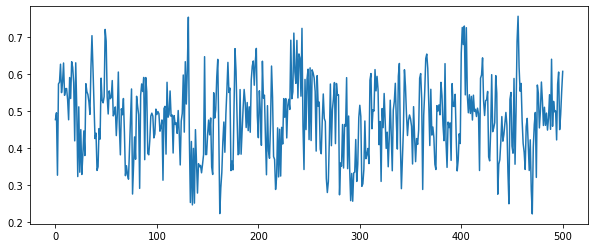

In [59]:
N,K=10,5
concentration_params = [10,10,10,10,10,10,10,10,10,10]

landscape = np.random.rand(N, 2**(K+1))
bit_fits = bit_fitness(landscape,N,K)
our_dirich = stats.dirichlet(concentration_params)
history = random_walker(500,bit_fits,our_dirich,N)
plt.figure(figsize=(10,4))
plt.plot(history)

max location 1101001100 max 0.8242287136791125
             Fitness                        Location  Maxima
0101001100  0.544404  (0, 1, 0, 1, 0, 0, 1, 1, 0, 0)       0
1001001100  0.642260  (1, 0, 0, 1, 0, 0, 1, 1, 0, 0)       0
1100001100  0.573195  (1, 1, 0, 0, 0, 0, 1, 1, 0, 0)       0
1101000100  0.646138  (1, 1, 0, 1, 0, 0, 0, 1, 0, 0)       0
1101001000  0.580088  (1, 1, 0, 1, 0, 0, 1, 0, 0, 0)       0
1101001101  0.770688  (1, 1, 0, 1, 0, 0, 1, 1, 0, 1)       0
1101001110  0.702636  (1, 1, 0, 1, 0, 0, 1, 1, 1, 0)       0
1101011100  0.617042  (1, 1, 0, 1, 0, 1, 1, 1, 0, 0)       0
1101101100  0.763272  (1, 1, 0, 1, 1, 0, 1, 1, 0, 0)       0
1111001100  0.580629  (1, 1, 1, 1, 0, 0, 1, 1, 0, 0)       0


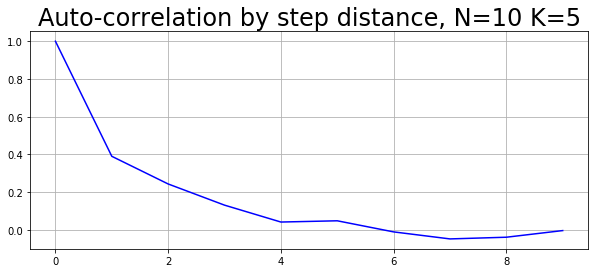

Max Fitness				 0.8242287136791125
Min Fitness				 0.22678933534933177
Normed difference in fitness		 6.094359702518646
Distance btw min and max		 5
Avg distance for 90th percentile to Max	 4.29126213592233
Num of Local Maxima			 45
Variance ratio is 0.44727958486958513
Fitness max: 0.8242287136791125
Fitness min: 0.5147186625025947
Fitness mean: 0.660504494687377


In [64]:
#Get Landscape statistics
Fitness_Sums = bit_fits.fitness.apply(lambda x: sum(x*our_dirich.rvs()[0]))
bit_fits.fitness = Fitness_Sums
bit_fits = bit_fits.rename(columns = {'fitness': 'Fitness'}, inplace = False)

landscape = Local_Maxima_Locations(bit_fits)
Get_Landscape_Statistics(landscape,N,K)
print_stats(landscape)



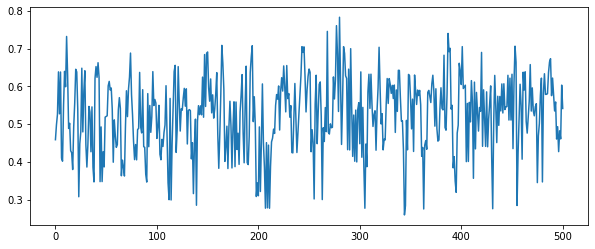

In [71]:
N,K=10,5
concentration_params = [10,20,30,40,50,60,50,40,30,20]

landscape = np.random.rand(N, 2**(K+1))
bit_fits = bit_fitness(landscape,N,K)
our_dirich = stats.dirichlet(concentration_params)

plt.figure(figsize=(10,4))
plt.plot(random_walker(500,bit_fits,our_dirich,N))

max location 1011000110 max 0.818862331085507
             Fitness                        Location  Maxima
0011000110  0.528844  (0, 0, 1, 1, 0, 0, 0, 1, 1, 0)       0
1001000110  0.756543  (1, 0, 0, 1, 0, 0, 0, 1, 1, 0)       0
1010000110  0.634336  (1, 0, 1, 0, 0, 0, 0, 1, 1, 0)       0
1011000010  0.585561  (1, 0, 1, 1, 0, 0, 0, 0, 1, 0)       0
1011000100  0.567544  (1, 0, 1, 1, 0, 0, 0, 1, 0, 0)       0
1011000111  0.493200  (1, 0, 1, 1, 0, 0, 0, 1, 1, 1)       0
1011001110  0.444466  (1, 0, 1, 1, 0, 0, 1, 1, 1, 0)       0
1011010110  0.519191  (1, 0, 1, 1, 0, 1, 0, 1, 1, 0)       0
1011100110  0.799827  (1, 0, 1, 1, 1, 0, 0, 1, 1, 0)       0
1111000110  0.632729  (1, 1, 1, 1, 0, 0, 0, 1, 1, 0)       0


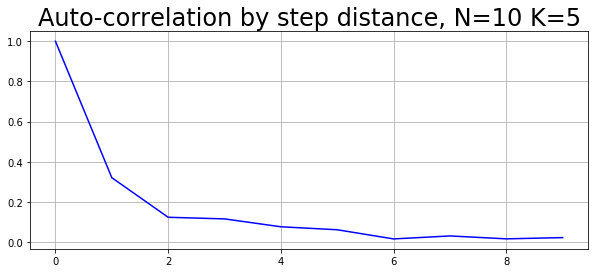

Max Fitness				 0.818862331085507
Min Fitness				 0.19938885375191295
Normed difference in fitness		 6.392030027782656
Distance btw min and max		 5
Avg distance for 90th percentile to Max	 4.660194174757281
Num of Local Maxima			 32
Variance ratio is 0.22945130032870367
Fitness max: 0.818862331085507
Fitness min: 0.6257398308655684
Fitness mean: 0.7044513998768749


In [72]:
#Get Landscape statistics
Fitness_Sums = bit_fits.fitness.apply(lambda x: sum(x*our_dirich.rvs()[0]))
bit_fits.fitness = Fitness_Sums
bit_fits = bit_fits.rename(columns = {'fitness': 'Fitness'}, inplace = False)

landscape = Local_Maxima_Locations(bit_fits)
Get_Landscape_Statistics(landscape,N,K)
print_stats(landscape)



max location 0001011010 max 0.7310552968206212
             Fitness                        Location  Maxima
0000011010  0.578071  (0, 0, 0, 0, 0, 1, 1, 0, 1, 0)       0
0001001010  0.611130  (0, 0, 0, 1, 0, 0, 1, 0, 1, 0)       0
0001010010  0.613438  (0, 0, 0, 1, 0, 1, 0, 0, 1, 0)       0
0001011000  0.708637  (0, 0, 0, 1, 0, 1, 1, 0, 0, 0)       0
0001011011  0.676044  (0, 0, 0, 1, 0, 1, 1, 0, 1, 1)       0
0001011110  0.554161  (0, 0, 0, 1, 0, 1, 1, 1, 1, 0)       0
0001111010  0.577056  (0, 0, 0, 1, 1, 1, 1, 0, 1, 0)       0
0011011010  0.655991  (0, 0, 1, 1, 0, 1, 1, 0, 1, 0)       0
0101011010  0.609466  (0, 1, 0, 1, 0, 1, 1, 0, 1, 0)       0
1001011010  0.669731  (1, 0, 0, 1, 0, 1, 1, 0, 1, 0)       0


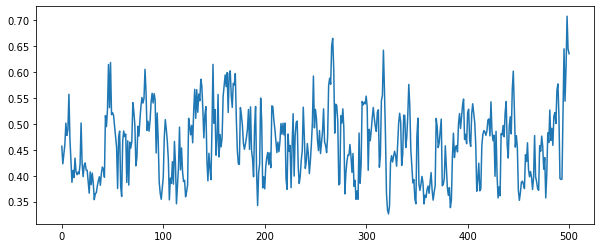

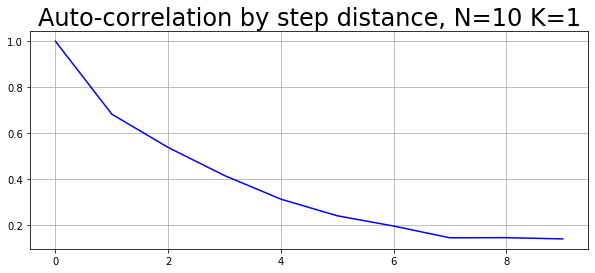

Max Fitness				 0.7310552968206212
Min Fitness				 0.304392563934887
Normed difference in fitness		 5.996867298141691
Distance btw min and max		 7
Avg distance for 90th percentile to Max	 2.883495145631068
Num of Local Maxima			 7
Variance ratio is 0.9884329430568564
Fitness max: 0.7310552968206212
Fitness min: 0.5227233737580836
Fitness mean: 0.5826673796391136


In [73]:
N,K=10,1
concentration_params = [10,20,30,40,50,60,50,40,30,20]

landscape = np.random.rand(N, 2**(K+1))
bit_fits = bit_fitness(landscape,N,K)
our_dirich = stats.dirichlet(concentration_params)

plt.figure(figsize=(10,4))
plt.plot(random_walker(500,bit_fits,our_dirich,N))

#Get Landscape statistics
Fitness_Sums = bit_fits.fitness.apply(lambda x: sum(x*our_dirich.rvs()[0]))
bit_fits.fitness = Fitness_Sums
bit_fits = bit_fits.rename(columns = {'fitness': 'Fitness'}, inplace = False)

landscape = Local_Maxima_Locations(bit_fits)
Get_Landscape_Statistics(landscape,N,K)
print_stats(landscape)



max location 1000111111 max 0.9015623969230517
             Fitness                        Location  Maxima
0000111111  0.588029  (0, 0, 0, 0, 1, 1, 1, 1, 1, 1)       0
1000011111  0.415124  (1, 0, 0, 0, 0, 1, 1, 1, 1, 1)       0
1000101111  0.621246  (1, 0, 0, 0, 1, 0, 1, 1, 1, 1)       0
1000110111  0.825258  (1, 0, 0, 0, 1, 1, 0, 1, 1, 1)       0
1000111011  0.871996  (1, 0, 0, 0, 1, 1, 1, 0, 1, 1)       0
1000111101  0.829673  (1, 0, 0, 0, 1, 1, 1, 1, 0, 1)       0
1000111110  0.834310  (1, 0, 0, 0, 1, 1, 1, 1, 1, 0)       0
1001111111  0.505125  (1, 0, 0, 1, 1, 1, 1, 1, 1, 1)       0
1010111111  0.391075  (1, 0, 1, 0, 1, 1, 1, 1, 1, 1)       0
1100111111  0.749021  (1, 1, 0, 0, 1, 1, 1, 1, 1, 1)       0


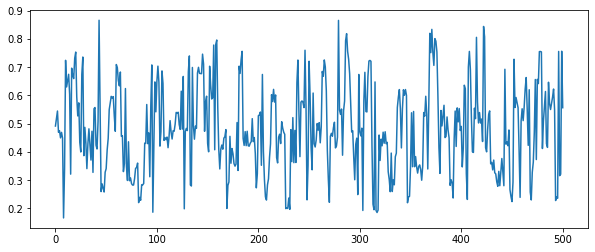

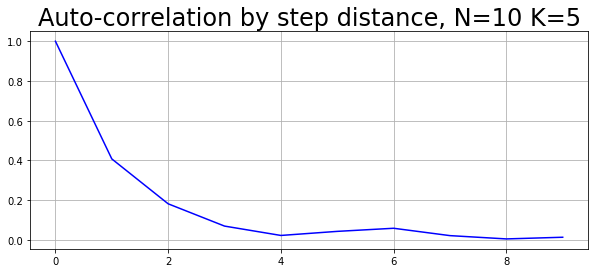

Max Fitness				 0.9015623969230517
Min Fitness				 0.12766411837123223
Normed difference in fitness		 4.889471375524689
Distance btw min and max		 7
Avg distance for 90th percentile to Max	 4.165048543689321
Num of Local Maxima			 26
Variance ratio is 0.2973261270432934
Fitness max: 0.9015623969230517
Fitness min: 0.5793267652513234
Fitness mean: 0.7586912685521613


In [75]:
N,K=10,5
concentration_params = [100,10,10,10,10,10,10,10, 10,100]

landscape = np.random.rand(N, 2**(K+1))
bit_fits = bit_fitness(landscape,N,K)
our_dirich = stats.dirichlet(concentration_params)

plt.figure(figsize=(10,4))
plt.plot(random_walker(500,bit_fits,our_dirich,N))

#Get Landscape statistics
Fitness_Sums = bit_fits.fitness.apply(lambda x: sum(x*our_dirich.rvs()[0]))
bit_fits.fitness = Fitness_Sums
bit_fits = bit_fits.rename(columns = {'fitness': 'Fitness'}, inplace = False)

landscape = Local_Maxima_Locations(bit_fits)
Get_Landscape_Statistics(landscape,N,K)
print_stats(landscape)



# Get Iterated Local Search Path History

In [78]:
N,K=10,5
concentration_params = [100,10,10,10,10,10,10,10, 10,100]

landscape = np.random.rand(N, 2**(K+1))
bit_fits = bit_fitness(landscape,N,K)
our_dirich = stats.dirichlet(concentration_params)


In [23]:

#create fitness history initialization
def get_iterated_search_walk_dirichlet(Landscape,Neighbor_Distance,Step_Size,Iterations,our_dirichlet):
    #initalize random position
    N=len(Landscape.iloc[0].Location)
    Position= Position_rand(N)
    #draw weights
    weights = our_dirichlet.rvs()[0]
    FitnessHistory=[sum(Landscape.loc["".join([str(i) for i in Position])].fitness*weights)]
    #record jumps down
    Jump_Down_history=[1]

    for j in range(Iterations):
        weights = our_dirichlet.rvs()[0]


        #Identify the Neighbors (distance of M from initial position row)
        Neighbors = Landscape[Landscape['Location'].apply(lambda row : sum(abs(np.array(row)-np.array(Landscape.loc["".join([str(i) for i in Position])].Location)))==Neighbor_Distance)]        #Get the maximum fitness value of the neighbors
        Neighbors.fitness = Neighbors.fitness.apply(lambda x: sum(x*weights))

        BetterNeighbors = Neighbors[Neighbors.fitness>sum(Landscape.loc["".join([str(i) for i in Position])].fitness*weights)]
        #randomize order of neighobrs then loop until one exceeds
        if len(BetterNeighbors)>0: #only update if there exists at least one superior neighobr
            BetterNeighbors.sample(frac=1)#randomly sample better neighbors
            Position = BetterNeighbors.index.values[0] #return the first index value
            Jump_Down_history.append(0)

        #take a step of size Step_Size
        else:
            Position = Perturbation(Position,Step_Size)
            Jump_Down_history.append(1)

            #Append to fitness data
        fit = sum(Landscape.loc["".join([str(i) for i in Position])].fitness*weights)
        FitnessHistory.append(fit)
        if j%300 ==1:
            print(j)
    return(FitnessHistory,Jump_Down_history)

In [141]:
N,K=10,1
concentration_params = [100,10,10,10,10,10,10,10, 10,100]

landscape = np.random.rand(N, 2**(K+1))
bit_fits = bit_fitness(landscape,N,K)
our_dirich = stats.dirichlet(concentration_params)

history_k1,Jump_history_1 = get_iterated_search_walk_dirichlet(bit_fits,1,2,50,our_dirich)
#history

In [142]:
N,K=10,5
concentration_params = [100,10,10,10,10,10,10,10, 10,100]

landscape = np.random.rand(N, 2**(K+1))
bit_fits = bit_fitness(landscape,N,K)
our_dirich = stats.dirichlet(concentration_params)

history_k5,Jump_history_5 = get_iterated_search_walk_dirichlet(bit_fits,1,2,50,our_dirich)
#history

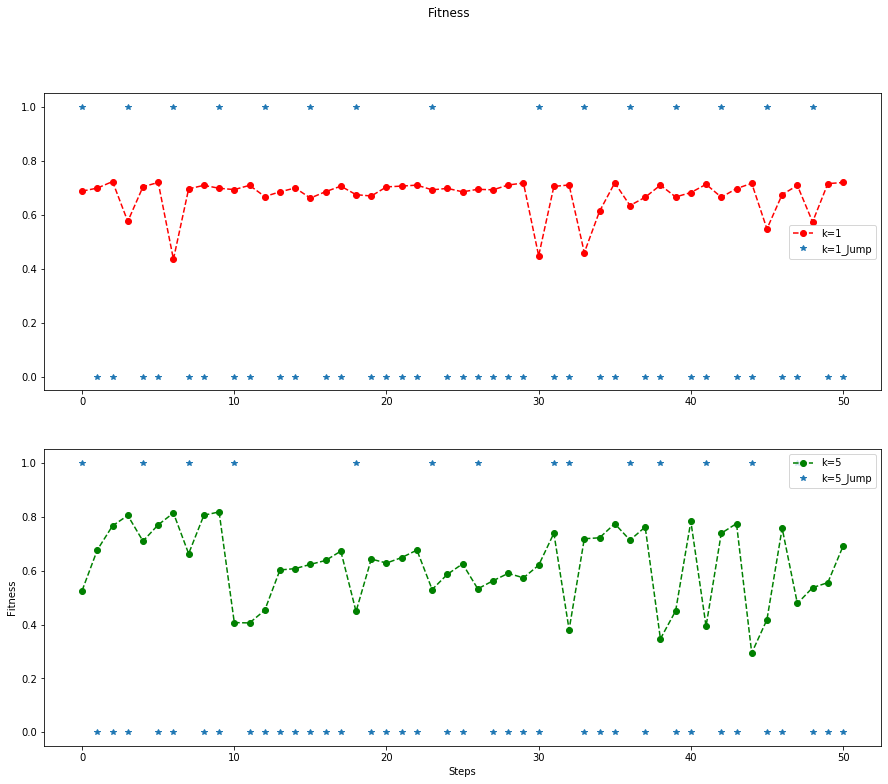

In [150]:


##plot the data
fig, (ax1,ax2) = plt.subplots(2)
fig.suptitle("Fitness")


ax1.plot((history_k1),'r--o',label='k=1')
ax1.plot((Jump_history_1),'*',label='k=1_Jump')

ax1.legend()
ax2.plot((history_k5),'g--o',label='k=5')
ax2.plot((Jump_history_5),'*',label='k=5_Jump')

ax2.legend()



fig.set_figheight(12)
fig.set_figwidth(15)

plt.xlabel('Steps')
plt.ylabel('Fitness')
plt.show()
fig.savefig('Plot_Iterated_Hill_Climbs.png')


In [9]:
bits = bit_fits.loc["".join([str(i) for i in current_loc])].fitness
weights = our_dirichlet.rvs()[0]
                            
return sum([i*j for i,j in zip(bits,weights)])

NameError: name 'bit_fits' is not defined

# Do model runs

In [41]:
#The jumps are recorded after the maxima as one
def get_maxima(Runs,Jumps):
    #Get index location of jumps (not including the starting position) and subtract by one, thats a maxima
    index_pos_list = [ i-1 for i in range(1,len(Jumps)) if Jumps[i] == 1 ]
    Runs=np.array(Runs)
    Maximas = np.array(Runs[index_pos_list])
    return(Maximas)
    #Get those index locations in the runs
    
    

In [42]:
get_maxima(Symmetrical_Runs[0],Symmetrical_Jumps[0])

array([0.5604981 , 0.56873935, 0.5598049 , 0.55995592, 0.57663462,
       0.57293619, 0.56129736, 0.56955244, 0.55626908, 0.56152459,
       0.56476175, 0.5797386 , 0.55665814, 0.56451946, 0.56756959,
       0.56960832, 0.55952206, 0.56188708, 0.56195227, 0.58013316,
       0.56776055, 0.55612601, 0.5824057 , 0.5599459 , 0.56979527,
       0.56197825, 0.55862843, 0.56261175, 0.56337846, 0.57078541,
       0.56777681, 0.57286475, 0.55555328, 0.55798525, 0.57084484,
       0.55331393, 0.55556147, 0.56030827, 0.56319031, 0.57510448,
       0.57610746, 0.57001857, 0.56606177, 0.56234469, 0.55353743,
       0.57258412, 0.5718108 , 0.56691754, 0.5642289 , 0.56424233,
       0.57997709, 0.57268827, 0.56541437, 0.56191282, 0.57294962,
       0.56435036, 0.55605048, 0.56005363, 0.57388157, 0.57291393,
       0.56506759, 0.57455342, 0.5610828 , 0.56175291, 0.5678927 ,
       0.55748568, 0.5638999 , 0.57006291, 0.57962266, 0.57264203,
       0.56037852, 0.56534265, 0.56191281, 0.56562254, 0.56432

In [30]:
params_symmetrical = [100,100,100,100,100,100,100,100,100,100]

N = 10
#If N=10, 2*2^N=2024
Num_Sims = 2*2**N
#Num_Sims = 20

concentration_params = params_symmetrical

Symmetrical_Runs =[]
Symmetrical_Jumps= []
for K in range(10):
    landscape = np.random.rand(N, 2**(K+1))
    bit_fits = bit_fitness(landscape,N,K)
    our_dirich = stats.dirichlet(concentration_params)
    Current_Climb, Current_Jumps= get_iterated_search_walk_dirichlet(bit_fits,1,2,Num_Sims,our_dirich)
    Symmetrical_Runs.append(Current_Climb)
    Symmetrical_Jumps.append(Current_Jumps)

    

1
301
601
901
1201
1501
1801
1
301
601
901
1201
1501
1801
1
301
601
901
1201
1501
1801
1
301
601
901
1201
1501
1801
1
301
601
901
1201
1501
1801
1
301
601
901
1201
1501
1801
1
301
601
901
1201
1501
1801
1
301
601
901
1201
1501
1801
1
301
601
901
1201
1501
1801
1
301
601
901
1201
1501
1801


In [264]:
###NOT the full number of sims
params_asymmetrical_neighbor = [100,100,100,1000,1000,100,100,100,100,100] 

N = 10
#If N=10, 2*2^N=2024
Num_Sims = 2**9
#Num_Sims = 20

concentration_params = params_asymmetrical_neighbor

asymmetrical_neighbor_Runs =[]
asymmetrical_neighbor_Jumps= []
for K in range(10):
    landscape = np.random.rand(N, 2**(K+1))
    bit_fits = bit_fitness(landscape,N,K)
    our_dirich = stats.dirichlet(concentration_params)
    Current_Climb, Current_Jumps= get_iterated_search_walk_dirichlet(bit_fits,1,2,Num_Sims,our_dirich)
    asymmetrical_neighbor_Runs.append(Current_Climb)
    asymmetrical_neighbor_Jumps.append(Current_Jumps)

    

1
301
1
301
1
301
1
301
1
301
1
301
1
301
1
301
1
301
1
301


In [44]:
params_asymmetrical_nonneighbor = [1000,100,100,1000,100,1000,100,100,100,100] 

N = 10
#If N=10, 2*2^N=2024
Num_Sims = 2*2**N
#Num_Sims = 20

concentration_params = params_asymmetrical_nonneighbor

asymmetrical_nonneighbor_Runs =[]
asymmetrical_nonneighbor_Jumps= []
for K in range(10):
    landscape = np.random.rand(N, 2**(K+1))
    bit_fits = bit_fitness(landscape,N,K)
    our_dirich = stats.dirichlet(concentration_params)
    Current_Climb, Current_Jumps= get_iterated_search_walk_dirichlet(bit_fits,1,2,Num_Sims,our_dirich)
    asymmetrical_nonneighbor_Runs.append(Current_Climb)
    asymmetrical_nonneighbor_Jumps.append(Current_Jumps)

    

1
301
601
901
1201
1501
1801
1
301
601
901
1201
1501
1801
1
301
601
901
1201
1501
1801
1
301
601
901
1201
1501
1801
1
301
601
901
1201
1501
1801
1
301
601
901
1201
1501
1801
1
301
601
901
1201
1501
1801
1
301
601
901
1201
1501
1801
1
301
601
901
1201
1501
1801
1
301
601
901
1201
1501
1801


In [265]:
#get Maximas
Maximas_Symmetrical=[get_maxima(Symmetrical_Runs[k],Symmetrical_Jumps[k]) for k in range(10)]
Maximas_Aymmetrical_Non_neighbor=[get_maxima(asymmetrical_nonneighbor_Runs[k],asymmetrical_nonneighbor_Jumps[k]) for k in range(10)]
Maximas_Aymmetrical_neighbor=[get_maxima(asymmetrical_neighbor_Runs[k],asymmetrical_neighbor_Jumps[k]) for k in range(10)]

#Maximas_Symmetrical=[get_maxima(Symmetrical_Runs[k],Symmetrical_Jumps[k]) for k in range(10)]

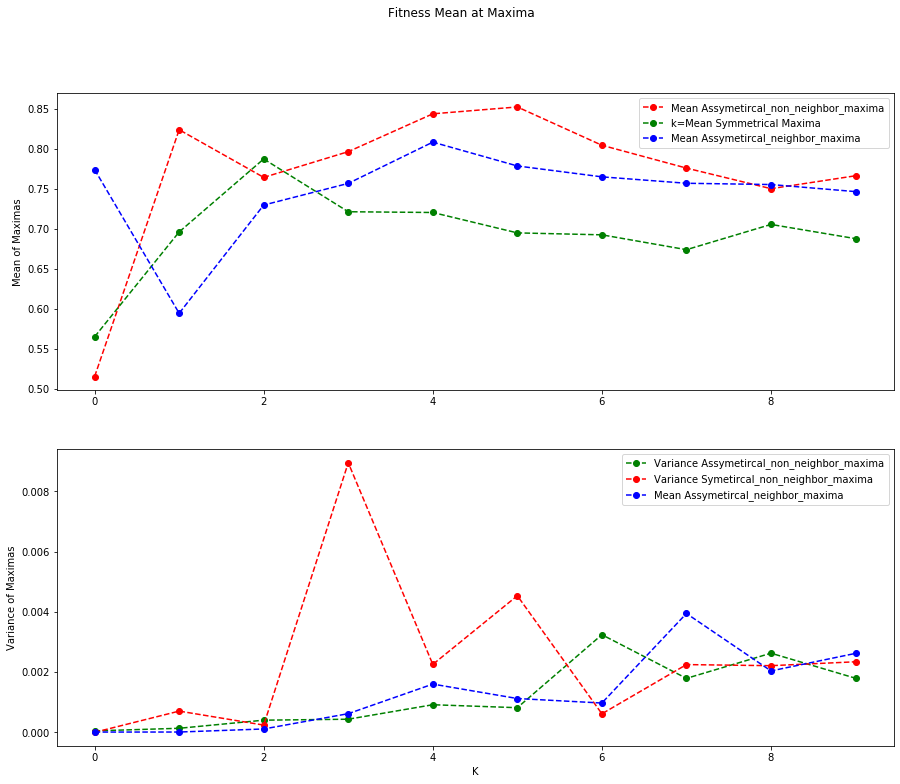

In [266]:


##plot the data
fig, (ax1,ax2) = plt.subplots(2)
fig.suptitle("Fitness Mean at Maxima")

ax1.plot(([sum(row)/len(row) for row in Maximas_Aymmetrical_Non_neighbor]),'r--o',label='Mean Asymetrical_non_neighbor_maxima')
ax1.plot(([sum(row)/len(row) for row in Maximas_Symmetrical]),'g--o',label='k=Mean Symetrical Maxima')
ax1.plot(([sum(row)/len(row) for row in Maximas_Aymmetrical_neighbor]),'b--o',label='Mean Asymetrical_neighbor_maxima')
ax1.set_ylabel('Mean of Maximas')


ax1.legend()
ax2.plot(([np.var(row) for row in Maximas_Symmetrical]),'g--o',label='Variance Assymetircal_non_neighbor_maxima')
ax2.plot(([np.var(row) for row in Maximas_Aymmetrical_Non_neighbor]),'r--o',label='Variance Symmetrical_non_neighbor_maxima')
ax2.plot(([np.var(row) for row in Maximas_Aymmetrical_neighbor]),'b--o',label='Mean Asymetrical_neighbor_maxima')
ax2.set_ylabel('Variance of Maximas')
ax2.legend()
plt.xlabel('K')



fig.set_figheight(12)
fig.set_figwidth(15)

plt.xlabel('K')
plt.show()
fig.savefig('Plot_Iterated_Hill_Climbs.png')


## Levinthalian search

In [206]:
##Recall they dont search all neighbors, just the best



#create fitness history initialization
def get_experimental_Group_Search(Landscape,Step_Size,Iterations,our_dirichlet,Num_Firms):
    #initalize random position
    N=len(Landscape.iloc[0].Location)
    Firms=[list(Position_rand(10)) for i in range(Num_Firms)]
    #Position= Position_rand(N)
    #draw weights
    weights = our_dirichlet.rvs()[0]
    Position_History=[]
    Position_History.append(Firms)

    #FitnessHistory=[sum(Landscape.loc["".join([str(i) for i in Position])].fitness*weights)]
    #record jumps down
    Jump_Down_history=[1]

    for j in range(Iterations):
        #if j>0:
        #    Fitness_Mean = sum(Fitnesses)/len(Fitnesses)
        #    Fitness_Max= max(Fitnesses)
        #    Genetic_Load = 1-Fitness_Mean/Fitness_Max
        weights = our_dirichlet.rvs()[0]
        Fitnesses=[] #get new fitnesses
        for f in range(len(Firms)):
            Position=Firms[f]
            #print(Position)
            Current_Fitness = sum(Landscape.loc["".join([str(i) for i in Position])].fitness*weights)
            #First check if you die
            #if j>0:
                

            
            #Identify the Neighbors (distance of M from initial position row)
            Neighbors = Landscape[Landscape['Location'].apply(lambda row : sum(abs(np.array(row)-np.array(Landscape.loc["".join([str(i) for i in Position])].Location)))==1)]        #Get the maximum fitness value of the neighbors
            Neighbors.fitness = Neighbors.fitness.apply(lambda x: sum(x*weights))

            BetterNeighbors = Neighbors[Neighbors.fitness>Current_Fitness]
            #randomize order of neighobrs then loop until one exceeds
            if len(BetterNeighbors)>0: #only update if there exists at least one superior neighobr
                BetterNeighbors.sample(frac=1)#randomly sample better neighbors
                Firms[f]= list(BetterNeighbors.index.values[0][:]) #return the first index value
            #potentially do a long jump
            else:
                New_Position = Position_rand(N)
                New_Fitness = sum(Landscape.loc["".join([str(i) for i in New_Position])].fitness*weights)
                if New_Fitness>Current_Fitness:
                    #print(';l')
                    Firms[f]=list(New_Position[:])
                    

                #Append to fitness data
            #Append fitness data
            Fitnesses.append(Current_Fitness)
            #Append location data

        Position_History.append(Firms[:])
            #print('l')
    return(Position_History)




# Get REsults of Levinthal 1997

In [ ]:
#Now Count unique
from collections import Counter 


In [255]:
params_symmetrical = [100,100,100,100,100,100,100,100,100,100]


N = 10
#If N=10, 2*2^N=2024
Num_Sims = 2
#Num_Sims = 20

concentration_params = params_symmetrical

symmetrical_Unique_Firms =[]
for K in range(10):
    print(K)
    Sim_Num_Unique=[]
    for sim in range(Num_Sims):
        landscape = np.random.rand(N, 2**(K+1))
        bit_fits = bit_fitness(landscape,N,K)
        our_dirich = stats.dirichlet(concentration_params)
        Num_Iterations=100
        Num_Firms=100
        Results = get_experimental_Group_Search(bit_fits,1,Num_Iterations,our_dirich,Num_Firms)


        Num_Unique = [len(Counter([tuple(i) for i in Current])) for Current in Results] 
        Sim_Num_Unique.append(Num_Unique)
    
    symmetrical_Unique_Firms.append(np.array(Sim_Num_Unique).mean(axis=0))

    

0


KeyboardInterrupt: 

In [222]:
params_asymmetrical_nonneighbor = [1000,100,100,1000,100,1000,100,100,100,100] 

N = 10
#If N=10, 2*2^N=2024
Num_Sims = 2
#Num_Sims = 20

concentration_params = params_asymmetrical_nonneighbor

asymmetrical_nonneighbor_Unique_Firms =[]
for K in range(10):
    Sim_Num_Unique=[]
    for sim in range(Num_Sims):
        landscape = np.random.rand(N, 2**(K+1))
        bit_fits = bit_fitness(landscape,N,K)
        our_dirich = stats.dirichlet(concentration_params)
        Num_Iterations=100
        Num_Firms=100
        Results = get_experimental_Group_Search(bit_fits,1,Num_Iterations,our_dirich,Num_Firms)


        Num_Unique = [len(Counter([tuple(i) for i in Current])) for Current in Results] 
        Sim_Num_Unique.append(Num_Unique)
    
    asymmetrical_nonneighbor_Unique_Firms.append(np.array(Sim_Num_Unique).mean(axis=0))

    

KeyboardInterrupt: 

In [ ]:
params_asymmetrical_neighbor = [100,100,100,1000,1000,100,100,100,100,100] 

N = 10
#If N=10, 2*2^N=2024
Num_Sims = 2
#Num_Sims = 20

concentration_params = params_asymmetrical_neighbor

asymmetrical_neighbor_Unique_Firms =[]
for K in range(10):
    Sim_Num_Unique=[]
    for sim in range(Num_Sims):
        landscape = np.random.rand(N, 2**(K+1))
        bit_fits = bit_fitness(landscape,N,K)
        our_dirich = stats.dirichlet(concentration_params)
        Num_Iterations=100
        Num_Firms=100
        Results = get_experimental_Group_Search(bit_fits,1,Num_Iterations,our_dirich,Num_Firms)


        Num_Unique = [len(Counter([tuple(i) for i in Current])) for Current in Results] 
        Sim_Num_Unique.append(Num_Unique)
    
    asymmetrical_neighbor_Unique_Firms.append(np.array(Sim_Num_Unique).mean(axis=0))

    